# Accessing higher energy states with Qiskit Pulse

## 2. Discriminating the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states <a id="discrim012"></a> 

Now that we have calibrated the $0, 1$ discriminator, we move on to exciting higher energy states. Specifically, we focus on exciting the $|2\rangle$ state and building a discriminator to classify $|0\rangle$, $|1\rangle$ and $2\rangle$ states from their respective IQ data points. The procedure for even higher states ($|3\rangle$, $|4\rangle$, etc.) should be similar, but we have not tested them explicitly.

The process for building the higher state discriminator is as follows:
1. Compute the $1\rightarrow2$ frequency.
2. Conduct a Rabi experiment to obtain the $\pi$ pulse amplitude for $1\rightarrow2$. To do this, we first apply a $0\rightarrow1$ $\pi$ pulse to get from the $|0\rangle$ to the $|1\rangle$ state. Then, we do a sweep of drive amplitudes at the $1\rightarrow2$ frequency obtained above.
3. Construct 3 schedules:\
    a. Zero schedule: just measure the ground state.\
    b. One schedule: apply a $0\rightarrow1$ $\pi$ pulse and measure.\
    c. Two schedule: apply a $0\rightarrow1$ $\pi$ pulse, then a $1\rightarrow2$ $\pi$ pulse and measure.
4. Separate the data from each schedule into training and testing sets and construct an LDA model for discrimination.

### 2A. Computing the 1->2 frequency <a id="freq12"></a>

The first step in our calibration is to compute the frequency needed to go from the $1\rightarrow2$ state. There are two methods to do this:
1. Do a frequency sweep from the ground state and apply very high power. If the applied power is large enough, two peaks should be observed. One at the $0\rightarrow1$ frequency found in section [1](#discrim01) and one at the $0\rightarrow2$ frequency. The $1\rightarrow2$ frequency can be obtained by taking the difference of the two. Unfortunately, for `ibmq_armonk`, the maximum drive power of $1.0$ is not sufficient to see this transition. Instead, we turn to the second method.
2. Excite the $|1\rangle$ state by applying a $0\rightarrow1$ $\pi$ pulse. Then perform the frequency sweep over excitations of the $|1\rangle$ state. A single peak should be observed at a frequency lower than the $0\rightarrow1$ frequency which corresponds to the $1\rightarrow2$ frequency.

#### 1->2 Frequency Sweep using the sideband method <a id="sideband12"></a>

We follow the second method described above. To drive the $0\rightarrow 1$ $\pi$ pulse, we require a local oscillator (LO) frequency given by the calibrated $0\rightarrow1$ frequency `cal_qubit_freq` (see construction of the Rabi $\pi$ pulse in section [1](#discrim01)). To sweep the range for the $1\rightarrow2$ frequency, however, we require varying the LO frequency. Unfortunately, the Pulse specification requires a single LO frequency per schedule. 

To resolve this, we set the LO frequency to `cal_qubit_freq` and multiply a sine function onto the $1\rightarrow2$ pulse at `freq-cal_qubit_freq`, where `freq` is the desired scan frequency. Applying the sinusoidal sideband, as it's known, enables us to change the LO frequency without manually setting it when assembling the program.

In [115]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-cal_qubit_freq)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse    

We wrap the logic for assembling the program in a method and run our program.

In [116]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: cal_qubit_freq}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.621607647077915 GHz to 5.021607647077915 GHz using 75 frequencies. The drive power is 0.3.


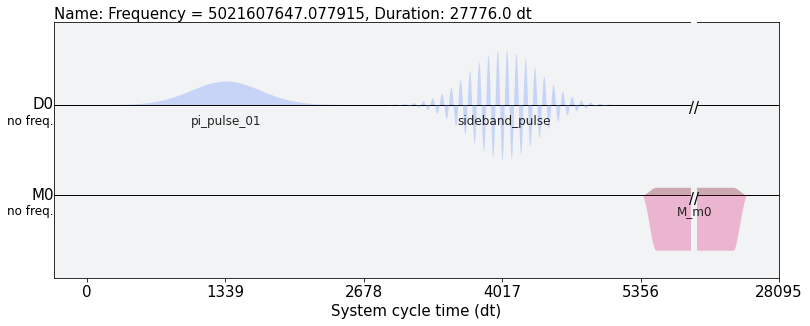

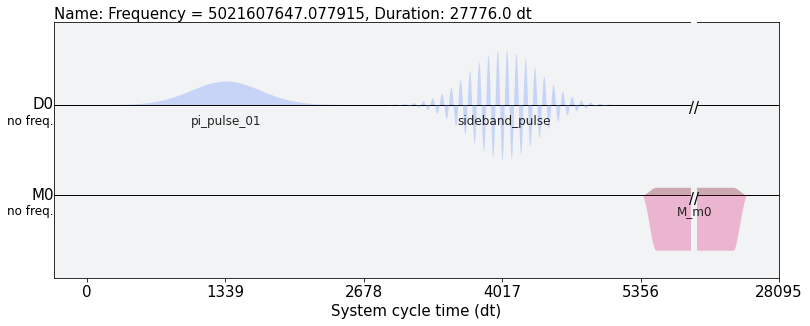

In [118]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = cal_qubit_freq + np.linspace(-350*MHz, 50*MHz, num_freqs) # OF: changed from (-400, 30)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [119]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [120]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

60ff774cc86dd27f33e78c86
Job Status: job has successfully run


In [121]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

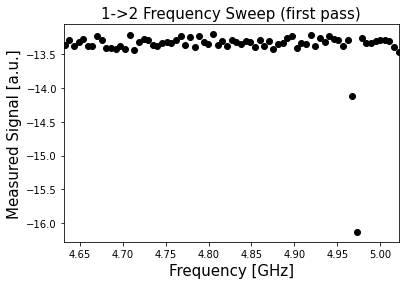

In [122]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

We see a maximum around $4.64$ GHz. There are a few spurious minima, but they are too large to be the $1\rightarrow2$ frequency. The maximum corresponds the $1\rightarrow2$ frequency. 

Using a relative maxima function, we compute the value of this point exactly. This gives an estimate for the $1\rightarrow2$ frequency.

In [57]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [58]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), 10)
approx_12_freq = maxima

Freq. dips:  []


We now use the estimate obtained above to do a refined sweep (i.e., much smaller range). This will allow us to obtain a more accurate value for the $1\rightarrow2$ frequency. We sweep $20$ MHz in each direction.

The frequency sweep will go from 4.60678631 GHz to 4.64678631 GHz using 75 frequencies. The drive power is 0.3.


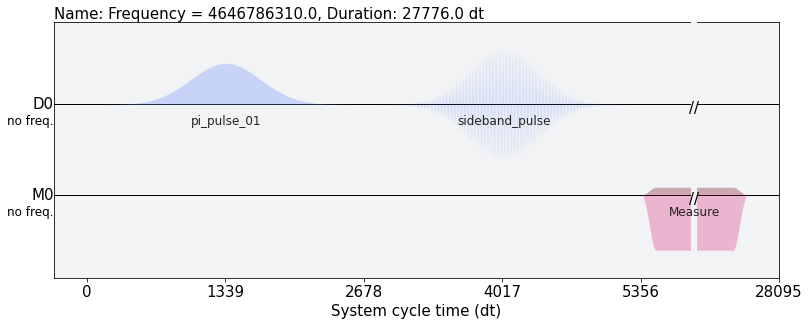

In [49]:
# smaller range refined sweep

num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [50]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

In [51]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

5f9690fc7b787b00147e8cbe
Job Status: job has successfully run


In [52]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

Let's plot and fit the refined signal, using the standard Lorentzian curve.

In [53]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [-12, 4.625*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

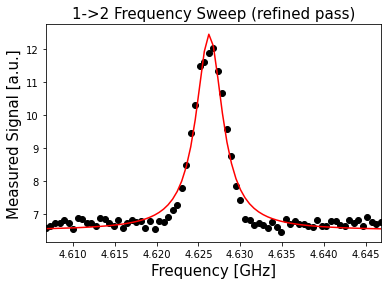

In [54]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [55]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6263002 GHz.


### 2B. 1->2 Rabi Experiment  <a id="rabi12"></a>

Now that we have a good estimate for the $1\rightarrow2$ frequency, we perform a Rabi experiment to obtain the $\pi$ pulse amplitude for the $1\rightarrow2$ transition. To do so, we apply a $0\rightarrow1$ $\pi$ pulse and then sweep over drive amplitudes at the $1\rightarrow2$ frequency (using the sideband method).

In [56]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [57]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [58]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: cal_qubit_freq}]
                                               * num_rabi_points)

In [59]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [60]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

5f96940d00cb39001375c22e
Job Status: job has successfully run


In [61]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

We plot and fit our data as before.

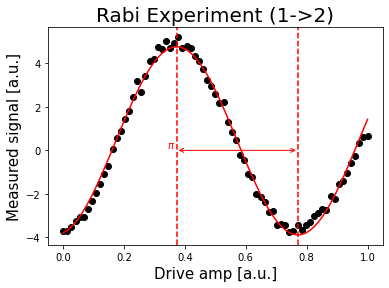

In [62]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps,
                            rabi_12_data, 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [3, 0.5, 0.9, 0])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps, rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [63]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6263002 GHz.
Pi Amplitude (1->2) = 0.37256049920143336


With this information, we can define our $1\rightarrow2$ $\pi$ pulse (making sure to add a sideband at the $1\rightarrow2$ frequency).

In [64]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

### 2C. Build the 0, 1, 2 discriminator <a id="builddiscrim012"></a>

Finally, we build our discriminator for the $|0\rangle$, $|1\rangle$ and $|2\rangle$ states. The procedure is analogous to section [1](#discrim01), however now we add an additional schedule for the $|2\rangle$ state.

As a review, our three schedules are (again, recalling that our system starts in the $|0\rangle$ state): 
1. Measure the $|0\rangle$ state directly (obtain $|0\rangle$ centroid).
2. Apply $0\rightarrow1$ $\pi$ pulse and then measure (obtain $|1\rangle$ centroid).
3.  Apply $0\rightarrow1$ $\pi$ pulse, then $1\rightarrow2$ $\pi$ pulse, then measure (obtain $|2\rangle$ centroid).

In [65]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

We construct the program and plot the centroids in the IQ plane.

In [66]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: cal_qubit_freq}] * 3)

In [67]:
IQ_012_job = backend.run(IQ_012_program)

In [68]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

5f969656d3b8890012128a9e
Job Status: job has successfully run


In [69]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [70]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

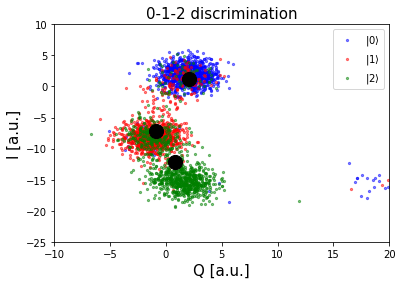

In [71]:
x_min = -10
x_max = 20
y_min = -25
y_max = 10
IQ_012_plot(x_min, x_max, y_min, y_max)

We now observe a third centroid corresponding to the $|2\rangle$ state. (Note: If the plot looks off, rerun the notebook.)

With this data, we can build our discriminator. Again, we use `scikit.learn` and Linear Discriminant Analysis (LDA).

We begin by shaping the data for LDA.

In [72]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


Next, we split our training and testing data (again, half and half). The testing data is a vector containing an array of `0`'s (for the zero schedule, `1`'s (for the one schedule) and `2`'s (for the two schedule).

In [73]:
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

3072


Finally, we set up our model and train it. The accuracy of our fit is printed.

In [74]:
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [75]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[0. 1. 1.]


In [76]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.826171875


The last step is to plot the separatrix. 

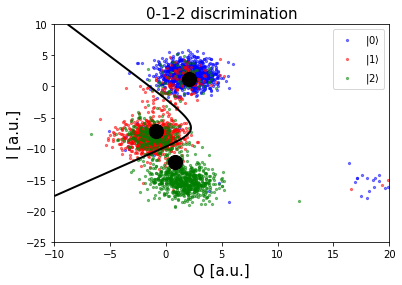

In [77]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

Now that we have 3 centroids, the separatrix is no longer a line, but rather a curve containing a combination of two lines. In order to discriminate between $|0\rangle$, $|1\rangle$ and $|2\rangle$ states, our model checks where the IQ point lies relative to the separatrix and classifies the point accordingly.

## 3. References <a id="refs"></a>

1. D. C. McKay, T. Alexander, L. Bello, M. J. Biercuk, L. Bishop, J. Chen, J. M. Chow, A. D. C ́orcoles, D. Egger, S. Filipp, J. Gomez, M. Hush, A. Javadi-Abhari, D. Moreda, P. Nation, B. Paulovicks, E. Winston, C. J. Wood, J. Wootton, and J. M. Gambetta, “Qiskit backend specifications for OpenQASM and OpenPulse experiments,” 2018, https://arxiv.org/abs/1809.03452.
2. Krantz, P. et al. “A Quantum Engineer’s Guide to Superconducting Qubits.” Applied Physics Reviews 6.2 (2019): 021318, https://arxiv.org/abs/1904.06560.
3. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011, https://scikit-learn.org/stable/modules/lda_qda.html#id4.

In [78]:
import qiskit.tools.jupyter
%qiskit_version_table